In [1]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

__Set Parameters for Loading Data + Analysis:__

In [3]:
#set file path of data folder
data_path = '../data/'

#set BC subtype to analyze
subtype = "HER2+" #options are "HER2+", "ER+", or "TNBC"

#set QC thresholds
nfeature_min = 200
nfeature_max = 2500
ncount_min = 500
percent_mt_max = 10

#set variable feature selection thresholds
n_highvarfeats = 2000
n_labels = 10

__Edit Data Into Correct Formatting__:
    
Data files need to be edited into a readable format before analysis can begin

1) genes.tsv

In [5]:
#load gene names file
df_genes = pd.read_csv('../data/genes.tsv', sep='\t', header=None, names=['GeneName'])

#create gene ID column
df_genes['GeneID'] = ['Gene_' + str(i) for i in range(len(df_genes))]

#order columns to match scanpy format
df_genes = df_genes[['GeneID', 'GeneName']]

#save to genes.tsv
df_genes.to_csv('../data/genes.tsv', sep='\t', index=False, header=False)

#load tsv file into DataFrame
df = pd.read_csv('../data/genes.tsv', sep='\t', header = None)
#print(df.head())

In [7]:
#read in data
adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache=True)
#print(adata)

2) metadata.csv

In [9]:
#load in metadata
metadata = pd.read_csv(data_path + 'metadata.csv')

In [11]:
#create cell_id header for unique cell identifiers
new_headers = ['cell_id'] + list(metadata.columns[1:])

In [13]:
#assign cell_id header to cells
metadata.columns = new_headers
#print(metadata.head())

In [15]:
#save metadata w/header
metadata.to_csv(data_path + 'metadata.csv', index=False)

In [17]:
#merge data + metadata by cell_id
adata.obs = adata.obs.join(metadata.set_index('cell_id'))
#print(adata.obs.head())

__Set AnnData Object for Downstream Analysis:__

In [19]:
#set copy of raw data
adata.raw = adata

__QC and Subsetting:__

In [21]:
#calculate % mitochondrial DNA per sample
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mt'] = adata[:, mito_genes].X.sum(axis=1) / adata.X.sum(axis=1) * 100
#print(adata.obs.head())

In [23]:
#filter samples based on QC metrics
adata = adata[(
    (adata.obs['nFeature_RNA'] > nfeature_min) &
    (adata.obs['nFeature_RNA'] < nfeature_max) &
    (adata.obs['nCount_RNA'] > ncount_min) &
    (adata.obs['percent_mt'] < percent_mt_max)
)]

In [25]:
#set samples to analyze to specified subtype
adata = adata[adata.obs['subtype'] == subtype]
print(adata.obs.head())

                         orig.ident  nCount_RNA  nFeature_RNA  percent.mito  \
CID3586_AAGACCTCAGCATGAG    CID3586        4581          1689      1.506221   
CID3586_AAGGTTCGTAGTACCT    CID3586        1726           779      5.793743   
CID3586_ACCAGTAGTTGTGGCC    CID3586        1229           514      1.383238   
CID3586_ACCCACTAGATGTCGG    CID3586        1352           609      1.923077   
CID3586_ACTTGTTAGGGAAACA    CID3586        1468           764      3.610354   

                         subtype    celltype_subset     celltype_minor  \
CID3586_AAGACCTCAGCATGAG   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_AAGGTTCGTAGTACCT   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCAGTAGTTGTGGCC   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACCCACTAGATGTCGG   HER2+  Endothelial ACKR1  Endothelial ACKR1   
CID3586_ACTTGTTAGGGAAACA   HER2+  Endothelial ACKR1  Endothelial ACKR1   

                         celltype_major  percent_mt  
CID3586_AAGACCTCAGCATGAG  

__Normalization:__

In [27]:
sc.pp.normalize_total(adata, target_sum=1e6)

/Users/joshuagalla/anaconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


__Visualization - Violin Plots:__

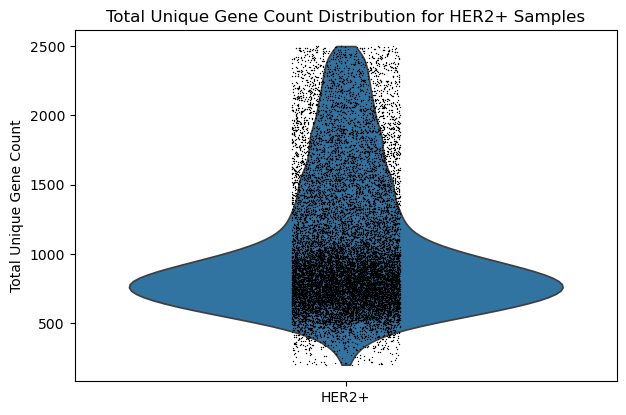

In [29]:
ax = sc.pl.violin(adata, ['nFeature_RNA'], stripplot = True, show = False)
ax.set_title(f'Total Unique Gene Count Distribution for {subtype} Samples')
ax.set_xlabel(f'{subtype}')
ax.set_ylabel('Total Unique Gene Count')
for label in ax.get_xticklabels():
    label.set_visible(False)
plt.show()

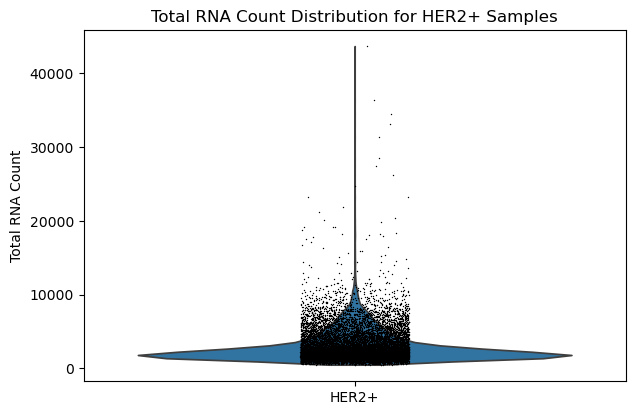

In [31]:
ax = sc.pl.violin(adata, ['nCount_RNA'], stripplot = True, show = False)
ax.set_title(f'Total RNA Count Distribution for {subtype} Samples')
ax.set_xlabel(f'{subtype}')
ax.set_ylabel('Total RNA Count')
for label in ax.get_xticklabels():
    label.set_visible(False)
plt.show()

__Visualization - Scatterplots:__

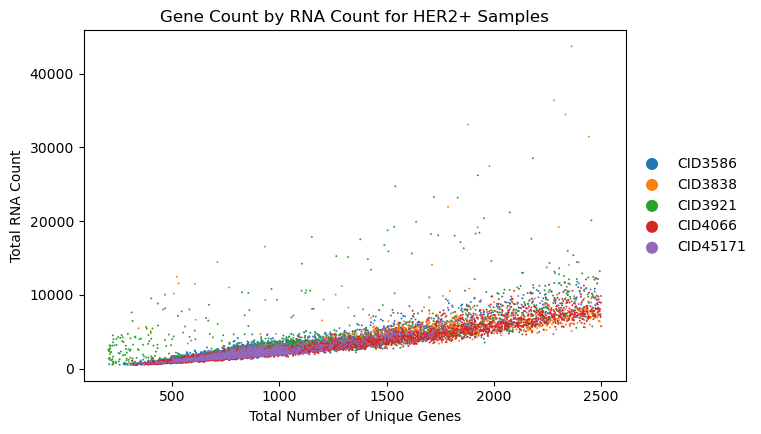

In [33]:
ax = sc.pl.scatter(adata, x='nFeature_RNA', y='nCount_RNA', color = 'orig.ident', title = f'Gene Count by RNA Count for {subtype} Samples', show = False)
ax.set_xlabel('Total Number of Unique Genes')
ax.set_ylabel('Total RNA Count')
plt.show()

__Highly Variable Feature Selection:__

In [35]:
sc.pp.log1p(adata)

In [37]:
sc.pp.highly_variable_genes(adata, n_top_genes=n_highvarfeats, flavor = 'seurat')

In [39]:
top_genes = adata.var[['highly_variable']].sort_values(by='highly_variable', ascending=False).head(10).index

for gene in top_genes:
    print(adata.var.loc[gene])
    print(' ')

gene_ids              Gene_0
highly_variable         True
means               0.103729
dispersions         6.930528
dispersions_norm    1.966569
Name: RP11-34P13.7, dtype: object
 
gene_ids            Gene_13870
highly_variable           True
means                 0.069488
dispersions           6.450031
dispersions_norm      1.082172
Name: RP11-417L19.2, dtype: object
 
gene_ids            Gene_9357
highly_variable          True
means                1.274755
dispersions          6.628542
dispersions_norm     1.084647
Name: RHOBTB2, dtype: object
 
gene_ids            Gene_9359
highly_variable          True
means                0.117003
dispersions          6.729152
dispersions_norm     1.595918
Name: RP11-875O11.2, dtype: object
 
gene_ids            Gene_9361
highly_variable          True
means                1.558434
dispersions          7.397347
dispersions_norm      2.68887
Name: TNFRSF10C, dtype: object
 
gene_ids            Gene_9362
highly_variable          True
means           

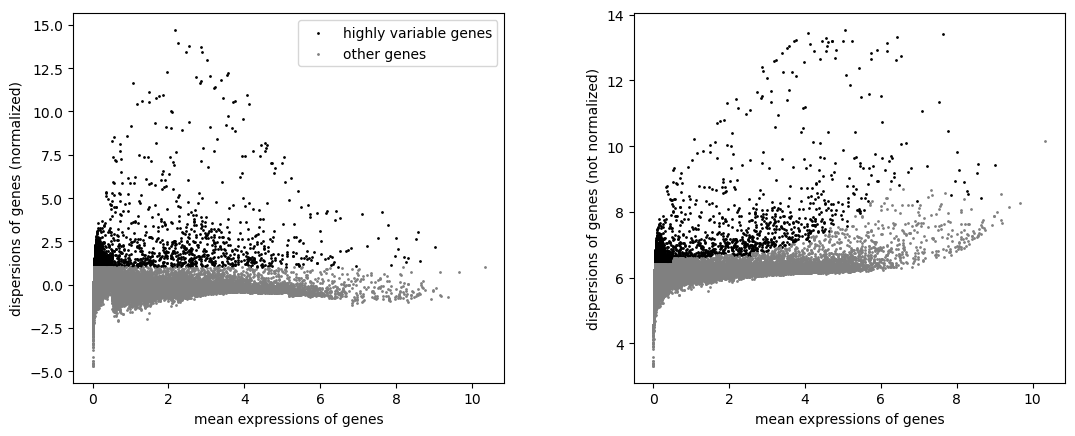

In [61]:
sc.pl.highly_variable_genes(adata, show=True)

__Scale Data:__

In [63]:
adata.raw = adata

In [65]:
sc.pp.scale(adata)

__PCA:__

In [67]:
sc.tl.pca(adata, svd_solver='arpack')

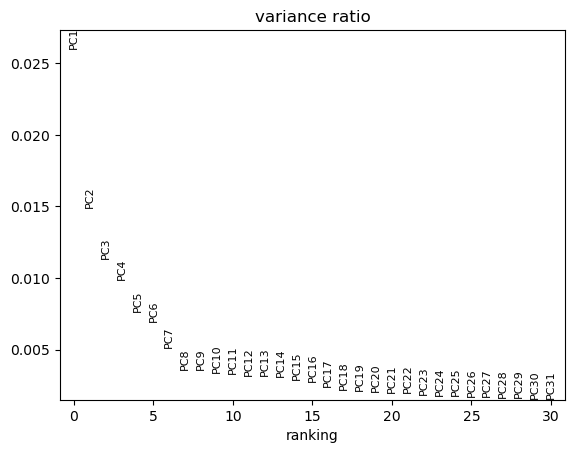

In [89]:
sc.pl.pca_variance_ratio(adata, show = True)

In [97]:
elbow_dims = 9 #set based on number of impactful dims above

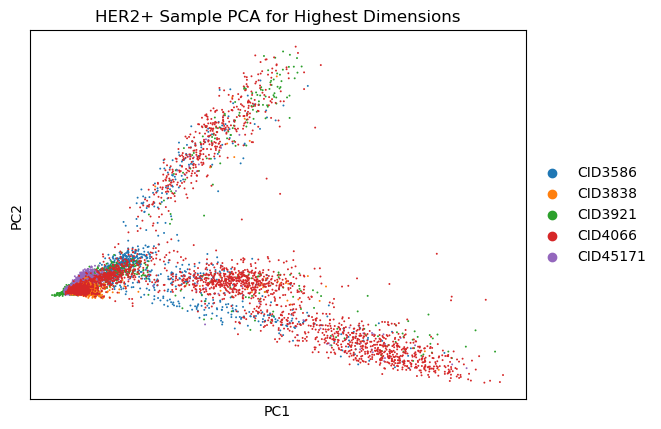

In [91]:
ax = sc.pl.pca(adata, color='orig.ident', show = False)
ax.set_title(f'{subtype} Sample PCA for Highest Dimensions')
plt.show()

__Clustering:__

In [100]:
sc.pp.neighbors(adata, n_pcs=elbow_dims)

In [102]:
sc.tl.leiden(adata, resolution=0.5)

ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

In [ ]:



# Step 11: UMAP -------------------
sc.tl.umap(adata)
sc.pl.umap(adata, color=['subtype'])

# Differential expression
data_markers = sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')

top_markers = pd.DataFrame(data_markers['names']).groupby('group').apply(lambda x: x.nlargest(10, 'logfoldchanges')).reset_index(drop=True)
print(top_markers)
HER2_ids = ["Naive CD4+ T", "Treg", "CD8+ T Cell", "Macrophage", "Helper T", "Cytotoxic T Cell", "Stem Cell", "Chondrocyte", "?", "B Cell", "Epithelial Cell", "NK Cell", "M2 Macrophage", "Memory B cell", "Granulocyte", "Keratinocyte", "CD27+ B Cell", "Epithelial Cell"]
adata.obs['cell_type'] = adata.obs['leiden'].map(your_mapping_dict)
